# Deep Learning
## Practice Projects
# P4: Style Recognition
## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. 

The command `hide_code` will display or hide the code cells.

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form> 

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


In [3]:
hide_code
plt.style.use('seaborn-whitegrid')

# Plot a fitting history for neural networks
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## Step 1. Load and Explore the Data
For this project, have made the database of photos sorted by products and brands. 

The main dataset (style.zip) is 2184 color images (150x150x3) with 7 brands and 10 products, and the file with labels style.csv. 

Photo files are in the .png format and the labels are integers and values.

Run the following cell to download the dataset.

In [4]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/" + img_path, target_size=(150, 150))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [5]:
hide_code
# Load and display the data
data = pd.read_csv("data/style.csv")
data.head()

brand_name  brand_label product_name  product_label         file
0  Christian Louboutin            0        shoes              0  0_0_001.png
1  Christian Louboutin            0        shoes              0  0_0_002.png
2  Christian Louboutin            0        shoes              0  0_0_003.png
3  Christian Louboutin            0        shoes              0  0_0_004.png
4  Christian Louboutin            0        shoes              0  0_0_005.png

Visualize distributions of variables to have an imagination of the database.

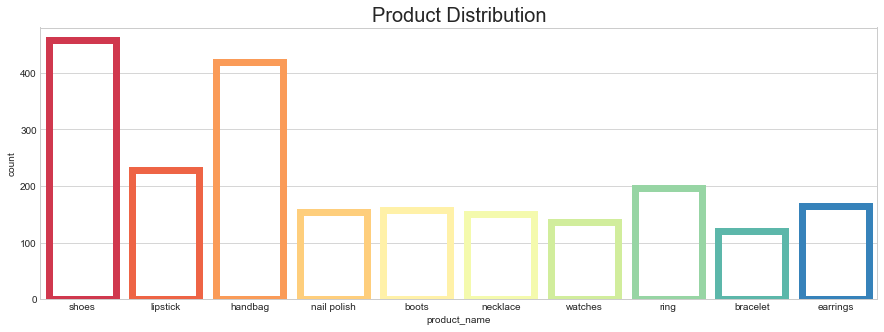

In [6]:
hide_code
# Plot the product distribution
plt.figure(figsize=(15,5))
sns.countplot(x="product_name", data=data,
              facecolor=(0, 0, 0, 0), linewidth=7,
              edgecolor=sns.color_palette("Spectral",10))
plt.title('Product Distribution', fontsize=20);

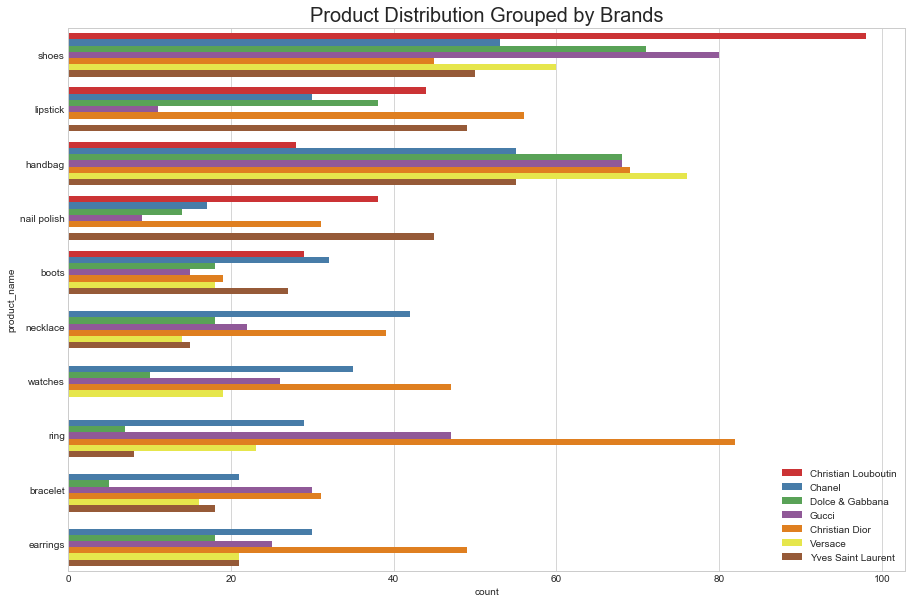

In [7]:
hide_code
# Plot the product distribution grouped by brand
plt.figure(figsize=(15,10))
sns.countplot(y="product_name", hue="brand_name", data=data, 
              palette=sns.color_palette("Set1",7))
plt.legend(loc=4)
plt.title('Product Distribution Grouped by Brands', 
          fontsize=20);

Print out the `brand_name` and `product_name` unique values.

In [8]:
hide_code
# Print unique values of brand names
set(data['brand_name'])

{'Chanel',
 'Christian Dior',
 'Christian Louboutin',
 'Dolce & Gabbana',
 'Gucci',
 'Versace',
 'Yves Saint Laurent'}

In [9]:
hide_code
# Print unique values of product names
set(data['product_name'])

{'boots',
 'bracelet',
 'earrings',
 'handbag',
 'lipstick',
 'nail polish',
 'necklace',
 'ring',
 'shoes',
 'watches'}

Let's create tensors of variables and display some examples of images.

In [10]:
hide_code
# Create tensors
brands = data['brand_label'].values
products = data['product_label'].values
images = data_to_tensor(data['file']);

100%|██████████| 2184/2184 [01:04<00:00, 33.97it/s]


In [11]:
hide_code
# Print the shape 
print ('Image shape:', images.shape)
print ('Brand shape', brands.shape)
print ('Product shape', products.shape)

Image shape: (2184, 150, 150, 3)
Brand shape (2184,)
Product shape (2184,)


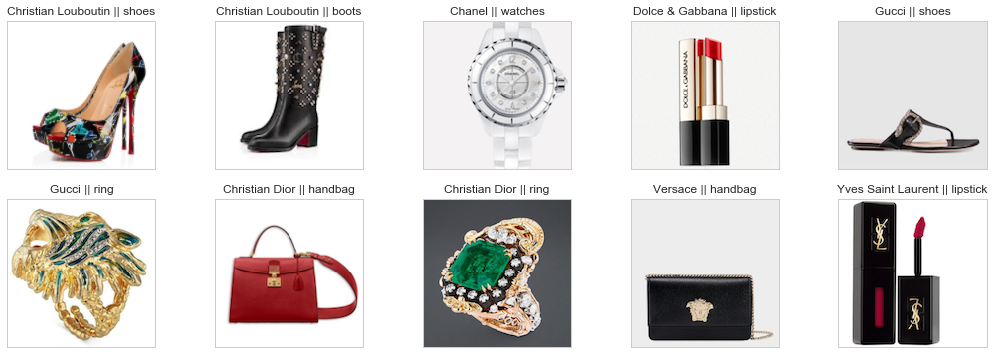

In [12]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[], 
                         title=data['brand_name'][i*218]+' || '+data['product_name'][i*218])
    display_images(data['file'][i*218], ax)

## Step 2. Save and Load the Data
The data tensors can be saved in the appropriate format of files `.h5`.

In [19]:
hide_code
# Create the tensor file
with h5py.File('StyleColorImages.h5', 'w') as f:
    f.create_dataset('images', data = images)
    f.create_dataset('brands', data = brands)
    f.create_dataset('products', data = products)
    f.close()

The next time it is possible to start here with neural network's experiments.

In [13]:
hide_code
# Read the h5 file
f = h5py.File('StyleColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['brands', 'images', 'products']

In [14]:
hide_code
# Create tensors and targets
brands = np.array(f[keys[0]])
images = np.array(f[keys[1]])
products = np.array(f[keys[2]])

print ('Image shape:', images.shape)
print ('Brand shape', brands.shape)
print ('Product shape', products.shape)

Image shape: (2184, 150, 150, 3)
Brand shape (2184,)
Product shape (2184,)


In [16]:
hide_code
# Create the csv file
images_csv = images.reshape(-1, 150*150*3)
np.savetxt("style_images.csv", images_csv, fmt='%i', delimiter=",")

In [17]:
hide_code
# Read the pandas dataframe from csv
data_images = pd.read_csv("style_images.csv", header=None)
data_images.iloc[:10,:10]

0    1    2    3    4    5    6    7    8    9
0  255  255  255  255  255  255  255  255  255  255
1  255  255  255  255  255  255  255  255  255  255
2  255  255  255  255  255  255  255  255  255  255
3  255  255  255  255  255  255  255  255  255  255
4  222  222  214  222  222  214  221  221  213  222
5  255  255  255  255  255  255  255  255  255  255
6  255  255  255  255  255  255  255  255  255  255
7  255  255  255  255  255  255  255  255  255  255
8  220  221  213  220  221  213  220  221  213  221
9   42   39   46   42   39   46   42   39   46   41

In [18]:
hide_code
# Read image tensors from the dataframe
images = data_images.values
images = images.reshape(-1,150,150,3)

## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized `numpy` array.

In [13]:
hide_code
# Normalize tensors
images = images.astype('float32')/255

Product:  handbag
Brand:  Gucci


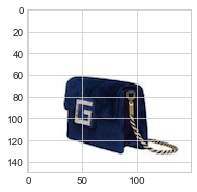

In [14]:
hide_code
# Read and display a tensor using Matplotlib
print('Product: ', data['product_name'][1000])
print('Brand: ', data['brand_name'][1000])
plt.figure(figsize=(3,3))
plt.imshow(images[1000]);

Create tensors of grayscaled images and display their shape.

In [15]:
hide_code
# Grayscaled tensors
gray_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_images.shape)

Grayscaled Tensor shape: (2184, 150, 150)


Product:  handbag
Brand:  Gucci


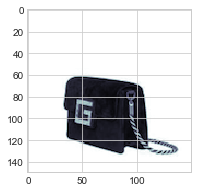

In [16]:
hide_code
# Read and display a tensor using Matplotlib
print('Product: ', data['product_name'][1000])
print('Brand: ', data['brand_name'][1000])
plt.figure(figsize=(3,3))
plt.imshow(gray_images[1000], cmap=cm.bone);

### One-hot Encode
Now we'll implement the one-hot encoding function `to_categorical`.

In [17]:
hide_code
# Print the brand unique values
print(set(brands))

{0, 1, 2, 3, 4, 5, 6}


In [18]:
hide_code
# Print the product unique values
print(set(products))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [19]:
hide_code
# One-hot encode the brands
cat_brands = to_categorical(brands, 7)
cat_brands.shape

(2184, 7)

In [20]:
hide_code
# One-hot encode the products
cat_products = to_categorical(products, 10)
cat_products.shape

(2184, 10)

### Multi-Label Target

In [21]:
hide_code
# Create multi-label targets
targets = np.concatenate((cat_brands, cat_products), axis=1)
targets.shape

(2184, 17)

### Split
Apply the function train_test_split and split the data into training and testing sets. Set up the size of the testing set - 20%.
#### Color Images, Brand Target

In [22]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(images, cat_brands, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [23]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Validating tensor's shape:", x_valid.shape)
print ("Validating target's shape", y_valid.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (1747, 150, 150, 3)
Training target's shape (1747, 7)
Validating tensor's shape: (218, 150, 150, 3)
Validating target's shape (218, 7)
Testing tensor's shape: (219, 150, 150, 3)
Testing target's shape (219, 7)


#### Color Images, Product Target

In [24]:
hide_code
# Split the data
x_train2, x_test2, y_train2, y_test2 = train_test_split(images, cat_products, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [25]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train2.shape)
print ("Training target's shape", y_train2.shape)
print ("Validating tensor's shape:", x_valid2.shape)
print ("Validating target's shape", y_valid2.shape)
print ("Testing tensor's shape:", x_test2.shape)
print ("Testing target's shape", y_test2.shape)

Training tensor's shape: (1747, 150, 150, 3)
Training target's shape (1747, 10)
Validating tensor's shape: (218, 150, 150, 3)
Validating target's shape (218, 10)
Testing tensor's shape: (219, 150, 150, 3)
Testing target's shape (219, 10)


#### Color Images, Multi-Label Target

In [26]:
hide_code
# Split the data
x_train3, x_test3, y_train3, y_test3 = train_test_split(images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test3)/2)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]

In [27]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train3.shape)
print ("Training target's shape", y_train3.shape)
print ("Validating tensor's shape:", x_valid3.shape)
print ("Validating target's shape", y_valid3.shape)
print ("Testing tensor's shape:", x_test3.shape)
print ("Testing target's shape", y_test3.shape)

Training tensor's shape: (1747, 150, 150, 3)
Training target's shape (1747, 17)
Validating tensor's shape: (218, 150, 150, 3)
Validating target's shape (218, 17)
Testing tensor's shape: (219, 150, 150, 3)
Testing target's shape (219, 17)


In [28]:
hide_code
# Create a list of targets
y_train3_list = [y_train3[:, :7], y_train3[:, 7:]]
y_test3_list = [y_test3[:, :7], y_test3[:, 7:]]
y_valid3_list = [y_valid3[:, :7], y_valid3[:, 7:]]

#### Grayscaled Images, Brand Target

In [29]:
hide_code
# Split the data
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_images, cat_brands, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test4)/2)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]

In [30]:
hide_code
# Reshape the grayscaled data
x_train4, x_test4, x_valid4 = \
x_train4.reshape(-1, 150, 150, 1), x_test4.reshape(-1, 150, 150, 1), x_valid4.reshape(-1, 150, 150, 1)

In [31]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train4.shape)
print ("Training target's shape", y_train4.shape)
print ("Validating tensor's shape:", x_valid4.shape)
print ("Validating target's shape", y_valid4.shape)
print ("Testing tensor's shape:", x_test4.shape)
print ("Testing target's shape", y_test4.shape)

Training tensor's shape: (1747, 150, 150, 1)
Training target's shape (1747, 7)
Validating tensor's shape: (218, 150, 150, 1)
Validating target's shape (218, 7)
Testing tensor's shape: (219, 150, 150, 1)
Testing target's shape (219, 7)


#### Grayscaled Images, Product Target

In [32]:
hide_code
# Split the data
x_train5, x_test5, y_train5, y_test5 = train_test_split(gray_images, cat_products, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test5)/2)
x_valid5, y_valid5 = x_test5[:n], y_test5[:n]
x_test5, y_test5 = x_test5[n:], y_test5[n:]

In [33]:
hide_code
# Reshape the grayscaled data
x_train5, x_test5, x_valid5 = \
x_train5.reshape(-1, 150, 150, 1), x_test5.reshape(-1, 150, 150, 1), x_valid5.reshape(-1, 150, 150, 1)

In [34]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train5.shape)
print ("Training target's shape", y_train5.shape)
print ("Validating tensor's shape:", x_valid5.shape)
print ("Validating target's shape", y_valid5.shape)
print ("Testing tensor's shape:", x_test5.shape)
print ("Testing target's shape", y_test5.shape)

Training tensor's shape: (1747, 150, 150, 1)
Training target's shape (1747, 10)
Validating tensor's shape: (218, 150, 150, 1)
Validating target's shape (218, 10)
Testing tensor's shape: (219, 150, 150, 1)
Testing target's shape (219, 10)


#### Grayscaled Images, Multi-Label Target

In [35]:
hide_code
# Split the data
x_train6, x_test6, y_train6, y_test6 = train_test_split(gray_images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test6)/2)
x_valid6, y_valid6 = x_test6[:n], y_test6[:n]
x_test6, y_test6 = x_test6[n:], y_test6[n:]

In [36]:
hide_code
# Reshape the grayscaled data
x_train6, x_test6, x_valid6 = \
x_train6.reshape(-1, 150, 150, 1), x_test6.reshape(-1, 150, 150, 1), x_valid6.reshape(-1, 150, 150, 1)

In [37]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train6.shape)
print ("Training target's shape", y_train6.shape)
print ("Validating tensor's shape:", x_valid6.shape)
print ("Validating target's shape", y_valid6.shape)
print ("Testing tensor's shape:", x_test6.shape)
print ("Testing target's shape", y_test6.shape)

Training tensor's shape: (1747, 150, 150, 1)
Training target's shape (1747, 17)
Validating tensor's shape: (218, 150, 150, 1)
Validating target's shape (218, 17)
Testing tensor's shape: (219, 150, 150, 1)
Testing target's shape (219, 17)


In [38]:
hide_code
# Create a list of targets
y_train6_list = [y_train6[:, :7], y_train6[:, 7:]]
y_test6_list = [y_test6[:, :7], y_test6[:, 7:]]
y_valid6_list = [y_valid6[:, :7], y_valid6[:, 7:]]

## Step 4. Create One-Label Classification Models
We should have an accuracy 

- greater than 14.3% for the first target (`brand`) and 

- greater than 10% for the second target (`product`).

#### Color Images, Brand Target

In [44]:
hide_code
def cb_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    # TODO: Compile the model    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cb_model = cb_model()

In [45]:
hide_code
# Create callbacks
cb_checkpointer = ModelCheckpoint(filepath='cb_model.styles.hdf5', 
                                  verbose=2, save_best_only=True)
cb_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                    patience=5, verbose=2, factor=0.5)

In [46]:
hide_code
# Train the model
cb_history = cb_model.fit(x_train, y_train, 
                          epochs=50, batch_size=16, verbose=2,
                          validation_data=(x_valid, y_valid),
                          callbacks=[cb_checkpointer,cb_lr_reduction])

Train on 1747 samples, validate on 218 samples
Epoch 1/50
 - 325s - loss: 1.9348 - acc: 0.2015 - val_loss: 1.9040 - val_acc: 0.2110

Epoch 00001: val_loss improved from inf to 1.90397, saving model to cb_model.styles.hdf5
Epoch 2/50
 - 400s - loss: 1.9185 - acc: 0.2221 - val_loss: 1.8528 - val_acc: 0.2385

Epoch 00002: val_loss improved from 1.90397 to 1.85280, saving model to cb_model.styles.hdf5
Epoch 3/50
 - 415s - loss: 1.8259 - acc: 0.2559 - val_loss: 1.8474 - val_acc: 0.2202

Epoch 00003: val_loss improved from 1.85280 to 1.84739, saving model to cb_model.styles.hdf5
Epoch 4/50
 - 349s - loss: 1.8127 - acc: 0.2879 - val_loss: 1.8383 - val_acc: 0.2477

Epoch 00004: val_loss improved from 1.84739 to 1.83834, saving model to cb_model.styles.hdf5
Epoch 5/50
 - 370s - loss: 1.7498 - acc: 0.3034 - val_loss: 1.7773 - val_acc: 0.3257

Epoch 00005: val_loss improved from 1.83834 to 1.77731, saving model to cb_model.styles.hdf5
Epoch 6/50
 - 349s - loss: 1.6801 - acc: 0.3371 - val_loss: 1.

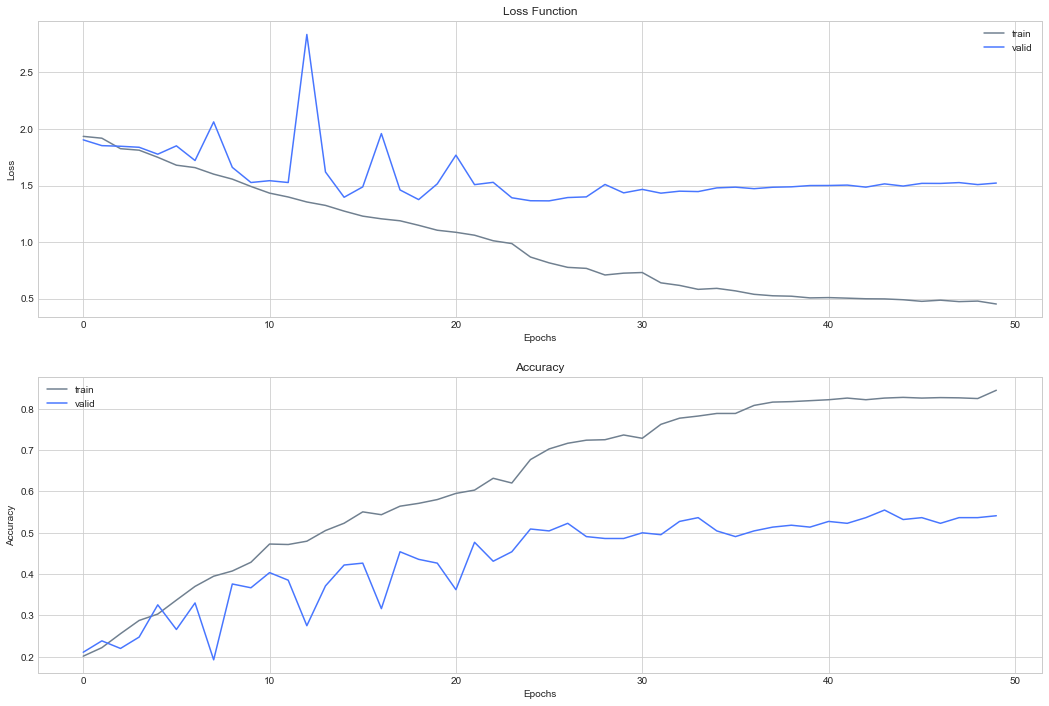

In [47]:
hide_code
# Plot the training history
history_plot(cb_history, 0)

In [48]:
hide_code
# Load the model with the best validation accuracy
cb_model.load_weights('cb_model.styles.hdf5')
# Calculate classification accuracy on the testing set
cb_score = cb_model.evaluate(x_test, y_test)
cb_score

219/219 [==============================] - 25s 114ms/step


[1.3096597864203257, 0.5844748836674102]

#### Color Images, Product Target

In [49]:
hide_code
def cp_model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cp_model = cp_model()

In [50]:
hide_code
# Create callbacks
cp_checkpointer = ModelCheckpoint(filepath='cp_model.styles.hdf5', 
                                  verbose=2, save_best_only=True)
cp_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                    patience=5, verbose=2, factor=0.5)

In [51]:
hide_code
# Train the model
cp_history = cp_model.fit(x_train2, y_train2, 
                          epochs=50, batch_size=16, verbose=2,
                          validation_data=(x_valid2, y_valid2),
                          callbacks=[cp_checkpointer,cp_lr_reduction])

Train on 1747 samples, validate on 218 samples
Epoch 1/50
 - 634s - loss: 2.1023 - acc: 0.2410 - val_loss: 1.9092 - val_acc: 0.2890

Epoch 00001: val_loss improved from inf to 1.90917, saving model to cp_model.styles.hdf5
Epoch 2/50
 - 323s - loss: 1.8082 - acc: 0.3326 - val_loss: 2.5884 - val_acc: 0.0963

Epoch 00002: val_loss did not improve from 1.90917
Epoch 3/50
 - 315s - loss: 1.6604 - acc: 0.3892 - val_loss: 2.0378 - val_acc: 0.2523

Epoch 00003: val_loss did not improve from 1.90917
Epoch 4/50
 - 312s - loss: 1.5842 - acc: 0.4179 - val_loss: 1.8535 - val_acc: 0.3532

Epoch 00004: val_loss improved from 1.90917 to 1.85347, saving model to cp_model.styles.hdf5
Epoch 5/50
 - 322s - loss: 1.4881 - acc: 0.4677 - val_loss: 2.8569 - val_acc: 0.1147

Epoch 00005: val_loss did not improve from 1.85347
Epoch 6/50
 - 361s - loss: 1.4134 - acc: 0.4900 - val_loss: 1.6599 - val_acc: 0.3716

Epoch 00006: val_loss improved from 1.85347 to 1.65993, saving model to cp_model.styles.hdf5
Epoch 7/5

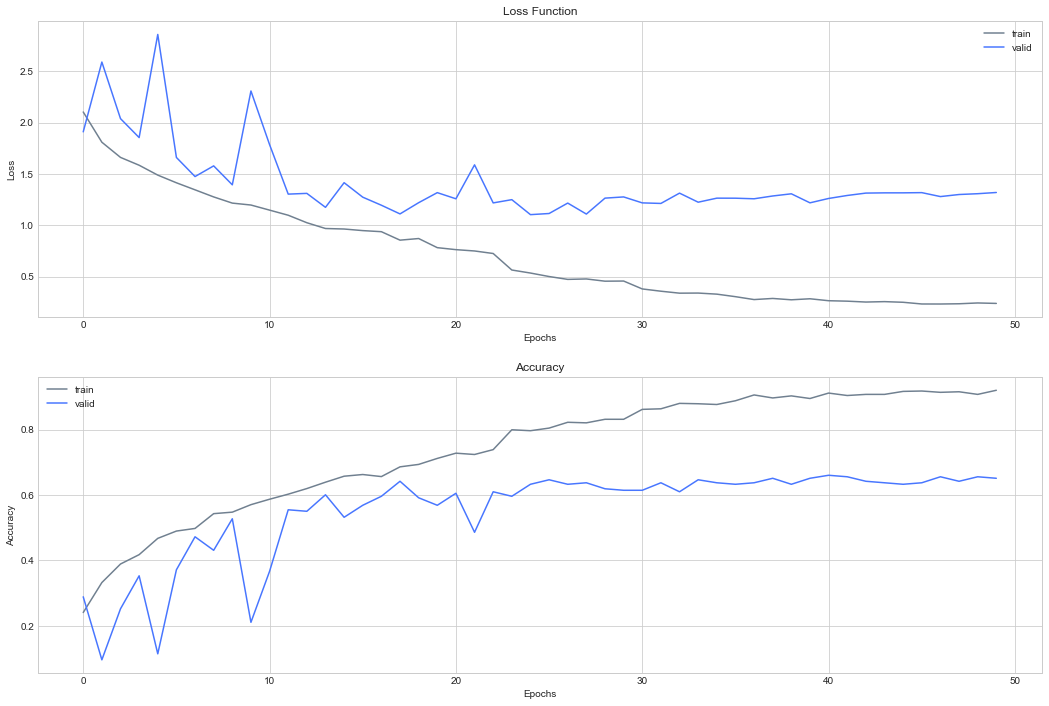

In [52]:
hide_code
# Plot the training history
history_plot(cp_history, 0)

In [53]:
hide_code
# Load the model with the best validation accuracy
cp_model.load_weights('cp_model.styles.hdf5')
# Calculate classification accuracy on the testing set
cp_score = cp_model.evaluate(x_test2, y_test2)
cp_score

219/219 [==============================] - 63s 286ms/step


[1.1334759024180234, 0.652968035441011]

#### Grayscaled Images, Brand Target

In [42]:
hide_code
def gray_cb_model():
    model = Sequential()
    
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train4.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

gray_cb_model = gray_cb_model()

In [43]:
hide_code
# Create callbacks
gray_cb_checkpointer = ModelCheckpoint(filepath='gray_cb_model.styles.hdf5', 
                                       verbose=2, save_best_only=True)
gray_cb_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                         patience=5, verbose=2, factor=0.2)

In [ ]:
hide_code
# Train the model
gray_cb_history = gray_cb_model.fit(x_train4, y_train4, 
                                    epochs=50, batch_size=16, verbose=2,
                                    validation_data=(x_valid4, y_valid4),
                                    callbacks=[gray_cb_checkpointer,gray_cb_lr_reduction])

Train on 1747 samples, validate on 218 samples
Epoch 1/50
 - 256s - loss: 1.9362 - acc: 0.2147 - val_loss: 1.9055 - val_acc: 0.2339

Epoch 00001: val_loss improved from inf to 1.90553, saving model to gray_cb_model.styles.hdf5
Epoch 2/50
 - 260s - loss: 1.8793 - acc: 0.2524 - val_loss: 1.8753 - val_acc: 0.2431

Epoch 00002: val_loss improved from 1.90553 to 1.87530, saving model to gray_cb_model.styles.hdf5
Epoch 3/50
 - 272s - loss: 1.8056 - acc: 0.2902 - val_loss: 1.7774 - val_acc: 0.3257

Epoch 00003: val_loss improved from 1.87530 to 1.77744, saving model to gray_cb_model.styles.hdf5
Epoch 4/50
 - 271s - loss: 1.7491 - acc: 0.3091 - val_loss: 1.7670 - val_acc: 0.2752

Epoch 00004: val_loss improved from 1.77744 to 1.76695, saving model to gray_cb_model.styles.hdf5
Epoch 5/50
 - 279s - loss: 1.6835 - acc: 0.3429 - val_loss: 1.6962 - val_acc: 0.3211

Epoch 00005: val_loss improved from 1.76695 to 1.69617, saving model to gray_cb_model.styles.hdf5
Epoch 6/50
 - 286s - loss: 1.6427 - a

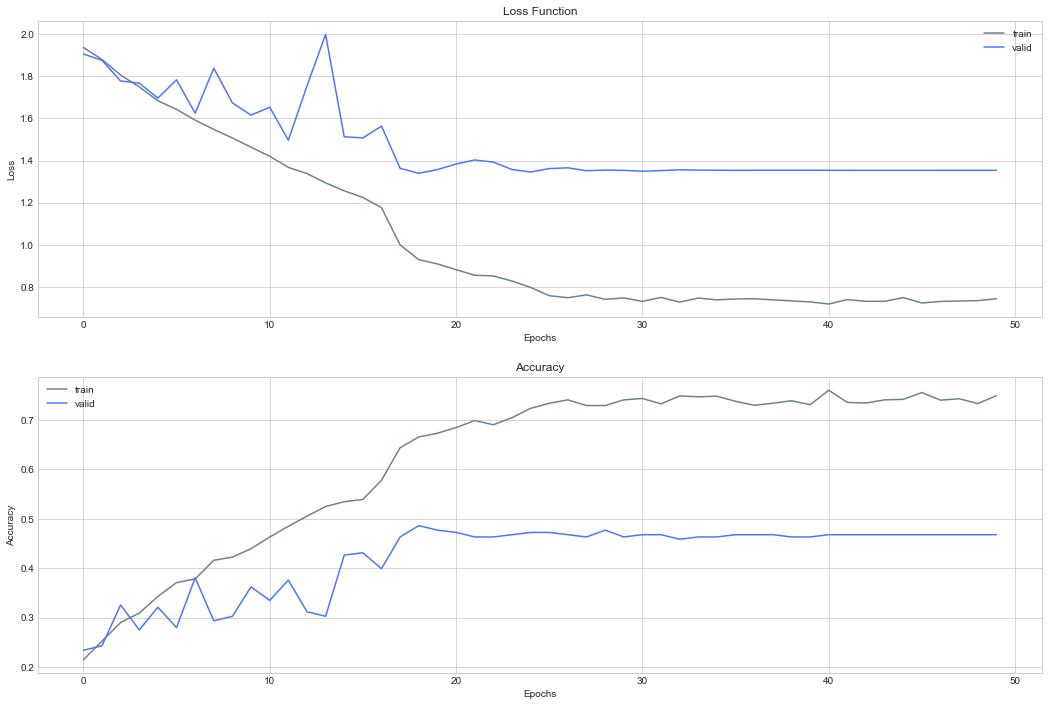

In [45]:
hide_code
# Plot the training history
history_plot(gray_cb_history, 0)

In [46]:
hide_code
# Load the model with the best validation accuracy
gray_cb_model.load_weights('gray_cb_model.styles.hdf5')
# Calculate classification accuracy on the testing set
gray_cb_score = gray_cb_model.evaluate(x_test4, y_test4)
gray_cb_score

219/219 [==============================] - 23s 103ms/step


[1.4617123037712758, 0.4657534260183709]

#### Grayscaled Images, Product Target

In [47]:
hide_code
def gray_cp_model():
    model = Sequential()
    
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train5.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

gray_cp_model = gray_cp_model()

In [48]:
hide_code
# Create callbacks
gray_cp_checkpointer = ModelCheckpoint(filepath='gray_cp_model.styles.hdf5', 
                                       verbose=2, save_best_only=True)
gray_cp_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                         patience=5, verbose=2, factor=0.2)

In [49]:
hide_code
# Train the model
gray_cp_history = gray_cp_model.fit(x_train5, y_train5, 
                                    epochs=50, batch_size=16, verbose=2,
                                    validation_data=(x_valid5, y_valid5),
                                    callbacks=[gray_cp_checkpointer,gray_cp_lr_reduction])

Train on 1747 samples, validate on 218 samples
Epoch 1/50
 - 371s - loss: 2.1360 - acc: 0.2169 - val_loss: 2.0709 - val_acc: 0.2202

Epoch 00001: val_loss improved from inf to 2.07093, saving model to gray_cp_model.styles.hdf5
Epoch 2/50
 - 290s - loss: 1.8916 - acc: 0.3234 - val_loss: 1.8948 - val_acc: 0.3073

Epoch 00002: val_loss improved from 2.07093 to 1.89485, saving model to gray_cp_model.styles.hdf5
Epoch 3/50
 - 342s - loss: 1.7145 - acc: 0.3950 - val_loss: 1.8560 - val_acc: 0.3578

Epoch 00003: val_loss improved from 1.89485 to 1.85597, saving model to gray_cp_model.styles.hdf5
Epoch 4/50
 - 342s - loss: 1.6098 - acc: 0.4264 - val_loss: 1.5903 - val_acc: 0.4633

Epoch 00004: val_loss improved from 1.85597 to 1.59032, saving model to gray_cp_model.styles.hdf5
Epoch 5/50
 - 346s - loss: 1.5243 - acc: 0.4688 - val_loss: 1.8132 - val_acc: 0.3945

Epoch 00005: val_loss did not improve from 1.59032
Epoch 6/50
 - 400s - loss: 1.4407 - acc: 0.5083 - val_loss: 1.5208 - val_acc: 0.4862

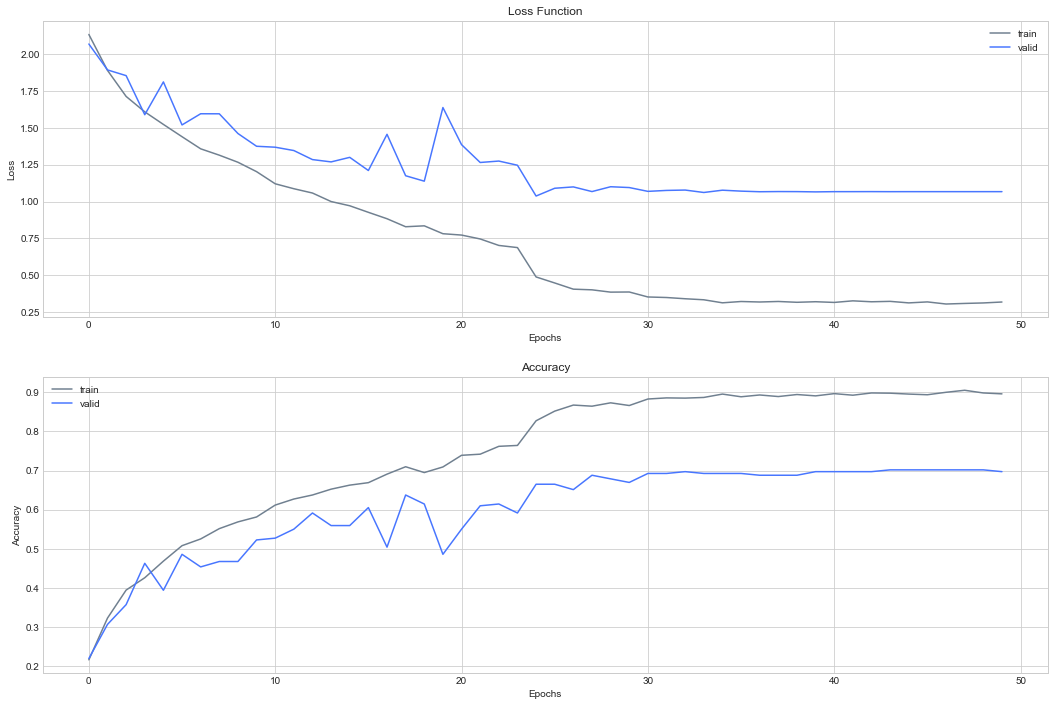

In [50]:
hide_code
# Plot the training history
history_plot(gray_cp_history, 0)

In [51]:
hide_code
# Load the model with the best validation accuracy
gray_cp_model.load_weights('gray_cp_model.styles.hdf5')
# Calculate classification accuracy on the testing set
gray_cp_score = gray_cp_model.evaluate(x_test5, y_test5)
gray_cp_score

219/219 [==============================] - 52s 239ms/step


[1.0037635834249732, 0.6575342482083464]

## Step 5. Create Multi-Label Classification Models

#### Color Images, Multi-Label Target

In [52]:
hide_code
def multi_model():    
    model_input = Input(shape=(150, 150, 3))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5),padding='same')(model_input)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(196, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(7, activation='softmax')(x)
    y2 = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

multi_model = multi_model()

In [53]:
hide_code
# Create callbacks
multi_checkpointer = ModelCheckpoint(filepath='multi_model.styles.hdf5', 
                                     verbose=2, save_best_only=True)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                       patience=5, verbose=2, factor=0.2)

In [54]:
hide_code
# Train the model
multi_history = multi_model.fit(x_train3, y_train3_list, 
                                validation_data=(x_valid3, y_valid3_list), 
                                epochs=30, batch_size=16, verbose=0, 
                                callbacks=[multi_checkpointer,multi_lr_reduction])


Epoch 00001: val_loss improved from inf to 3.95420, saving model to multi_model.styles.hdf5

Epoch 00002: val_loss did not improve from 3.95420

Epoch 00003: val_loss improved from 3.95420 to 3.75990, saving model to multi_model.styles.hdf5

Epoch 00004: val_loss improved from 3.75990 to 3.65722, saving model to multi_model.styles.hdf5

Epoch 00005: val_loss improved from 3.65722 to 3.36591, saving model to multi_model.styles.hdf5

Epoch 00006: val_loss improved from 3.36591 to 3.32579, saving model to multi_model.styles.hdf5

Epoch 00007: val_loss improved from 3.32579 to 3.31468, saving model to multi_model.styles.hdf5

Epoch 00008: val_loss improved from 3.31468 to 3.25431, saving model to multi_model.styles.hdf5

Epoch 00009: val_loss improved from 3.25431 to 3.24478, saving model to multi_model.styles.hdf5

Epoch 00010: val_loss improved from 3.24478 to 3.09012, saving model to multi_model.styles.hdf5

Epoch 00011: val_loss did not improve from 3.09012

Epoch 00012: val_loss did 

In [55]:
hide_code
# Load the model with the best validation accuracy
multi_model.load_weights('multi_model.styles.hdf5')
# Calculate classification accuracy on the testing set
multi_scores = multi_model.evaluate(x_test3, y_test3_list, verbose=0)

print("Scores: \n" , (multi_scores))
print("First label. Accuracy: %.2f%%" % (multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (multi_scores[4]*100))

Scores: 
 [2.6864930941089646, 1.4126377318003407, 1.2738553448899153, 0.5251141557954762, 0.6255707740783691]
First label. Accuracy: 52.51%
Second label. Accuracy: 62.56%


#### Grayscaled Images, Multi-Label Target

In [56]:
hide_code
def gray_multi_model():    
    model_input = Input(shape=(150, 150, 1))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), padding='same')(model_input)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(196, (5, 5))(x) 
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(7, activation='softmax')(x)
    y2 = Dense(10, activation='softmax')(x)
       
    model = Model(inputs=model_input, outputs=[y1, y2])
    # TODO: Compile the model

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])   
    return model

gray_multi_model = gray_multi_model()

In [57]:
hide_code
# Create callbacks
gray_multi_checkpointer = ModelCheckpoint(filepath='gray_multi_model.styles.hdf5', 
                                          verbose=2, save_best_only=True)
gray_multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, verbose=2, factor=0.2)

In [59]:
hide_code
# Train the model
gray_multi_history = gray_multi_model.fit(x_train6, y_train6_list, 
                                          validation_data=(x_valid6, y_valid6_list), 
                                          epochs=30, batch_size=16, verbose=0, 
                                          callbacks=[gray_multi_checkpointer,
                                                     gray_multi_lr_reduction])


Epoch 00001: val_loss improved from inf to 3.71692, saving model to gray_multi_model.styles.hdf5

Epoch 00002: val_loss improved from 3.71692 to 3.56347, saving model to gray_multi_model.styles.hdf5

Epoch 00003: val_loss improved from 3.56347 to 3.53995, saving model to gray_multi_model.styles.hdf5

Epoch 00004: val_loss improved from 3.53995 to 3.29303, saving model to gray_multi_model.styles.hdf5

Epoch 00005: val_loss did not improve from 3.29303

Epoch 00006: val_loss did not improve from 3.29303

Epoch 00007: val_loss improved from 3.29303 to 3.15776, saving model to gray_multi_model.styles.hdf5

Epoch 00008: val_loss did not improve from 3.15776

Epoch 00009: val_loss did not improve from 3.15776

Epoch 00010: val_loss improved from 3.15776 to 3.12744, saving model to gray_multi_model.styles.hdf5

Epoch 00011: val_loss improved from 3.12744 to 3.09433, saving model to gray_multi_model.styles.hdf5

Epoch 00012: val_loss improved from 3.09433 to 2.94499, saving model to gray_mult

In [60]:
hide_code
# Load the model with the best validation accuracy
gray_multi_model.load_weights('gray_multi_model.styles.hdf5')
# Calculate classification accuracy on the testing set
gray_multi_scores = gray_multi_model.evaluate(x_test6, y_test6_list, verbose=0)

print("Scores: \n" , (gray_multi_scores))
print("First label. Accuracy: %.2f%%" % (gray_multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (gray_multi_scores[4]*100))

Scores: 
 [2.3777328179851516, 1.2813794035889787, 1.0963534318148818, 0.5433789959781246, 0.6392694033988534]
First label. Accuracy: 54.34%
Second label. Accuracy: 63.93%
